# Impacto de la deforestación en el regimen de caudales de los rios en Colombia (TEAM 28)

## Multivariate time series forecasting

Sources :

https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015

### Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.vector_ar as var
import sklearn.metrics as skm

from statsmodels.tsa.stattools import grangercausalitytests # Granger's Causality Test

from statsmodels.graphics.tsaplots import plot_acf # Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf # PartialAutocorrelation plot

from sklearn.model_selection import train_test_split # Split data for machine learning

from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import coint  # Johansen Test for Cointegration (Just two data series)

from coint_johansen import coint_johansen  # Johansen Test for Cointegration more two data series
from scipy.stats import zscore # Calculates the z score of each value in the sample, relative to the sample mean and standard deviation.

from sklearn.utils import check_array # Para calculo de MAPE

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num = None, figsize = (15, 12), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (15, 10), 
                     'figure.max_open_warning': 20000})

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

<Figure size 1200x960 with 0 Axes>

In [2]:
print(plt.rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

### Read Data

In [3]:
macrodata = pd.read_csv('../data/matrix/matrix_consol_v2.zip')

macrodata.head(10)

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
0,2000-01,2000,1,7,230.4,0.000000,334.0,NaN
1,2000-02,2000,2,7,272.4,0.000133,400.0,NaN
2,2000-03,2000,3,7,321.6,0.000265,319.0,NaN
3,2000-04,2000,4,7,310.8,0.000398,248.0,NaN
4,2000-05,2000,5,7,410.0,0.000531,302.0,NaN
5,2000-06,2000,6,7,295.9,0.000663,81.0,NaN
6,2000-07,2000,7,7,244.2,0.000796,96.0,NaN
7,2000-08,2000,8,7,255.0,0.000928,64.0,NaN
8,2000-09,2000,9,7,233.8,0.001061,262.0,NaN
9,2000-10,2000,10,7,216.0,0.001194,141.0,NaN


In [4]:
mcs = macrodata['mc'].unique()
mcs.sort()

print(mcs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


### Check if the data is random

A quick test is to check if the data is random. Random data will not exhibit a structure in the lag plot.

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 
                       'v_rainfall_total', 'v_temperature_mean']]

    main_title = 'Macro basin ' + str(i)
    
    temp_df = temp_df.apply(zscore)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (15,10))
    temp_df.plot(ax = ax1, title = main_title)
    pd.plotting.lag_plot(temp_df, ax = ax2, lag = 1)
    pd.plotting.lag_plot(temp_df, ax = ax3, lag = 2)
    plt.show()

The random structure should look like the following graph.

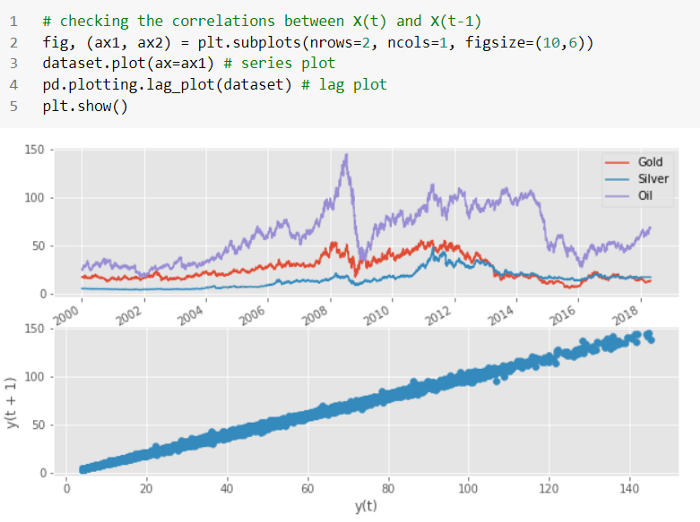

### Seasonal-Trend decomposition

#### Variable v_flow_mean

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_flow_mean[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_flow_mean'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_loss_cover

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_loss_cover[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_loss_cover'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_rainfall_total

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_rainfall_total[macrodata['mc'] == i].copy()
    main_title = 'Macro basin ' + str(i) + ' Variable v_rainfall_total'
    fig, ax = plt.subplots(len(attr), 1, sharex=True)
    sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)
    
    for idx, a in enumerate(attr):
        s_attr = getattr(sd, a)
        s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
        ax[idx].set(ylabel = a)

#### Variable v_temperature_mean (prevents macro-basins with null values)

In [ ]:
attr = ['observed', 'trend', 'seasonal', 'resid']

for i in mcs:
    temp_df = macrodata.v_temperature_mean[macrodata['mc'] == i].copy()
    if (temp_df.isnull().sum() == 0):
        temp_df = temp_df.fillna(temp_df)
        main_title = 'Macro basin ' + str(i) + ' Variable v_temperature_mean'
        fig, ax = plt.subplots(len(attr), 1, sharex=True)
        sd = sm.tsa.seasonal_decompose(temp_df, model = 'additive', period = 12)

        for idx, a in enumerate(attr):
            s_attr = getattr(sd, a)
            s_attr.plot(ax = ax[idx], title = main_title if idx == 0 else None)
            ax[idx].set(ylabel = a)

### Autocorrelation plots

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 
                       'v_rainfall_total', 'v_temperature_mean']]
    
    for j in temp_df:
        fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (15,3))
        plot_acf(temp_df[j], lags = 50, ax = ax1)
        plt.title('MC = %s - ACF for %s' % (i, j))
        plt.show()

### Granger's Causality Test

Causalidad de Wiener-Granger o Test de Wiener-Granger: Desarrollado por el Premio en Ciencias Económicas en memoria de Alfred Nobel (año 2003) Clive W. J. Granger (1934-2009), a partir de las indicaciones de Norbert Wiener. Es un test consistente en comprobar si los resultados de una variable sirven para predecir a otra variable, si tiene carácter unidireccional o bidireccional. Para ello se tiene que comparar y deducir si el comportamiento actual y el pasado de una serie temporal A predice la conducta de una serie temporal B. Si ocurre el hecho, se dice que “el resultado A” causa en el sentido de Wiener-Granger “el resultado B”; el comportamiento es unidireccional. Si sucede lo explicado e igualmente “el resultado B” predice “el resultado A”, el comportamiento es bidireccional, entonces “el resultado A” causa “el resultado B”, y “el resultado B” causa “el resultado A”. 

https://www.analyticslane.com/2019/11/18/test-de-causalidad-de-wiener-granger/

$H_0 $ : NO existe una relación entre las variables.

$H_a $ : SI existe una relación entre las variables.

Si p-value < $\alpha$ (0.05) se rechaza $H_0 $; lo que implica que SI hay relación entre las variables.

In [ ]:
def likelihood_Granger(mbasin, granger_result, max_lags):
    
    mBasin_Granger = []

    lk_p_val = 12
    pval = 100
    foundit = False
    
    for i in range(1,max_lags):
        pval = 100
        
        for x in list((list(granger_result[mbasin][i])))[0:1]:
            lk_lag = x.get('lrtest', None)
            p_val = lk_lag[1]
            
            if (p_val < 0.05):
                mBasin_Granger.append(i)
                mBasin_Granger.append(p_val)
                foundit = True
#                 print(x)
#                 print(lk_lag, p_val)
                break
                
        if (foundit == True):
            break
            
    return(mBasin_Granger)

#### v_flow_mean vs v_loss_cover

In [ ]:
mc_stat_fl_lc = []
mc_stat_fl_lc_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_loss_cover']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('-------')
    granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                          verbose = True)
    granger_test
    mc_stat_fl_lc_nnull.append(i)
    mc_stat_fl_lc.append(granger_test)    
    print('\n')

#### v_flow_mean vs v_rainfall_total

In [ ]:
mc_stat_fl_rf = []
mc_stat_fl_rf_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_rainfall_total']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('-------')
    granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                          verbose = True)
    granger_test
    mc_stat_fl_rf_nnull.append(i)
    mc_stat_fl_rf.append(granger_test) 
    print('\n')

#### v_flow_mean vs v_temperature_mean (prevents macro-basins with null values)

In [ ]:
mc_stat_fl_tp = []
mc_stat_fl_tp_nnull = []

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i][['v_flow_mean', 'v_temperature_mean']].copy().reset_index(drop = True)
    
    if (temp_df['v_temperature_mean'].isnull().sum() == 0):
        print('MC = ', i)
        print('-------')
        granger_test = sm.tsa.stattools.grangercausalitytests(temp_df, maxlag = 12, 
                                                              verbose = True)
        granger_test
        mc_stat_fl_tp_nnull.append(i)
        mc_stat_fl_tp.append(granger_test) 
        print('\n')

### Stationarity check

Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted. The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data. In contrast to the non-stationary process that has a variable variance and a mean that does not remain near, or returns to a long-run mean over time, the stationary process reverts around a constant long-term mean and has a constant variance independent of time.

https://www.investopedia.com/articles/trading/07/stationary.asp

Augmented Dickey-Fuller Test (ADF) Statistical Test

To determine if a time series is stationary or not, we will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:

Ho : Null Hypothesis states there is the presence of a unit root.

Ha : Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.

In [ ]:
def adf_test(mbasin, ts, ts_name, signif = 0.05):
    dftest = adfuller(ts, autolag = 'AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']    
    
    stationary = 0
    
    ls_stationary = []
    ls_stationary.append(mbasin)
    ls_stationary.append(ts_name)
    
    if p <= signif:
        print(' >>> ', ts_name, 'series is Stationary')
        stationary = 1
        
    else:
        print(' >>> ', ts_name, 'series is Non-Stationary')
        stationary = 0
    
    print('Size : ', ts.shape)
    print()
    
    ls_stationary.append(stationary)
    
    return(stationary, ls_stationary)

In [ ]:
list_stationary = []
df_stationary = pd.DataFrame()
    
for i in mcs:
    temp_df1 = macrodata[macrodata['mc'] == i][['v_flow_mean']].copy().reset_index(drop = True)
    temp_df2 = macrodata[macrodata['mc'] == i][['v_rainfall_total']].copy().reset_index(drop = True)
    temp_df3 = macrodata[macrodata['mc'] == i][['v_loss_cover']].copy().reset_index(drop = True)
    temp_df4 = macrodata[macrodata['mc'] == i][['v_temperature_mean']].copy().reset_index(drop = True)
    
    print('MC = ', i)
    print('--------------------------------------', '\n')

    #apply adf test on the series
    stationary, ls_stationary = adf_test(i, temp_df1, 'v_flow_mean')
    list_stationary.append([i, 'v_flow_mean', stationary])
    
    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary], axis = 0)
    
    stationary, ls_stationary = adf_test(i, temp_df2, 'v_rainfall_total')
    list_stationary.append([i, 'v_rainfall_total', stationary])

    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary])
    
    stationary, ls_stationary = adf_test(i, temp_df3, 'v_loss_cover')
    list_stationary.append([i, 'v_loss_cover', stationary])
                                     
    tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                               'is_stationary'])
    df_stationary = pd.concat([df_stationary, tmp_df_stationary])
                                     
    if (temp_df4['v_temperature_mean'].isnull().sum() == 0):
        stationary, ls_stationary = adf_test(i, temp_df4, 'v_temperature_mean')
        list_stationary.append([i, 'v_temperature_mean', stationary])
                                     
        tmp_df_stationary = pd.DataFrame([ls_stationary], columns = ['mbasin', 'var_name', 
                                                                   'is_stationary'])
        df_stationary = pd.concat([df_stationary, tmp_df_stationary])  
        
    print('\n')

data_train_stationary = pd.DataFrame(list_stationary)
data_train_stationary.columns = ['mc', 'variable', 'stationary']
data_train_stationary = data_train_stationary.set_index(['mc', 'variable', ]).unstack().swaplevel(0, axis = 1).sort_index(axis = 1)

data_train_stationary.head(48)

In [ ]:
df_stationary.head(20)

In [ ]:
temp_df = df_stationary.pivot(index = 'mbasin', columns = 'var_name', 
                              values = 'is_stationary').reset_index(drop = False)

temp_df.head()

In [ ]:
temp_df.to_csv('../model/mc_stationary.csv', index = False)

### Johansen Test for Cointegration

The Johansen test is based on time series analysis. The ADF test is based on an autoregressive model, a value from a time series is regressed on previous values from the same time series. When there are more than one variables, you can still write the relationship of the current prices as a linear function of the past prices in an autoregressive model, but to be more precise this model is then called the Vector Error Correction Model (VECM). Given below is the equation for VECM.

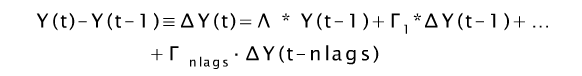

In this equation, we have multidimensional variables and hence the multiplication will be matrix multiplication. The coefficients for each of the lag terms in this equation are therefore vector terms.

In the Johansen test, we check whether lambda has a zero eigenvalue. When all the eigenvalues are zero, that would mean that the series are not cointegrated, whereas when some of the eigenvalues contain negative values, it would imply that a linear combination of the time series can be created, which would result in stationarity.

The linear combination of these prices represents the net market value of the portfolio. If the change in the value of the portfolio is related to its current value by a negative regression coefficient or in this case a negative eigenvalue, then we would have a mean reverting or stationary portfolio. This is the essence of the Johansen Test.

Fuente : https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/

#### Cointegration vs. Correlation

In quantitative trading, we usually work with non-stationary time-series. Often, people consider correlated for two assets when these assets co-move, but this term is mathematically incorrect in this context. Pearson’s correlation is defined for stationary variables only. As we see, this formula uses expected values and standard deviations, but these values are changing over time in non-stationary processes.

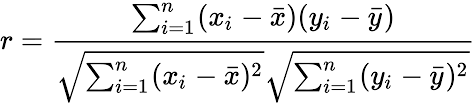

For these processes, we can define the cointegration. Cointegration refers to some stationary linear combination of several non-stationary time-series. Easy explanation you can find in this video https://youtu.be/vvTKjm94Ars

This picture shows two processes (X and Y), and their spread. This is an example of the correlation with no cointegration.

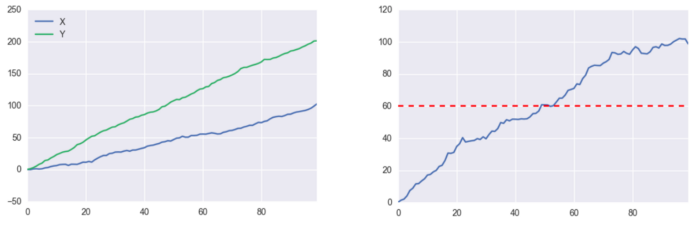

This example is vice versa (cointegration with no correlation)

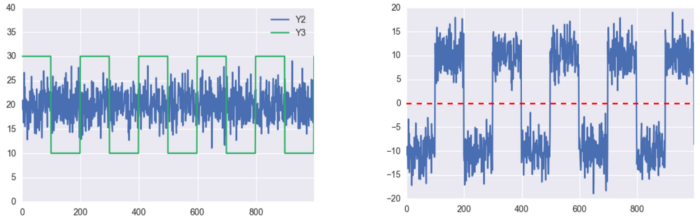

Fuente : https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015

We then call the coint_johansen function by passing the data frame storing the time series data, 0 and 1 as its three arguments. The second term in the arguments represents the order of null hypothesis, a value of 0 implies that it is a constant term, there is no time trend in the polynomial. The third term specifies the number of lagged difference terms used when computing the estimator, here we use a single lagged difference term.

In [ ]:
for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.head(10)

    print('MC = ', i)
   
    coint_johansen(temp_df, 0, 1)
    
    print('\n')

### Series transformation

A difference transform is a simple way for removing a systematic structure from the time series. We will remove trend by subtracting the previous value from each value in the series which is the first order differencing. To keep it simple, we will do first order differencing or seasonal differencing.

If we have an integrated order to n time series and if we take first order to difference and time, we will be left with series integrated order of zero.

In [ ]:
macrodata['v_flow_mean_log'] = np.log(macrodata['v_flow_mean'] + 1)
macrodata['v_loss_cover_log'] = np.log(macrodata['v_loss_cover'] + 1)
macrodata['v_rainfall_total_log'] = np.log(macrodata['v_rainfall_total'] + 1)

# data_train['v_flow_mean_log_diff'] = (data_train['v_flow_mean_log']).diff().dropna()
# data_train['v_loss_cover_log_diff'] = (data_train['v_loss_cover_log']).diff().dropna()
# data_train['v_rainfall_total_log_diff'] = (data_train['v_rainfall_total_log']).diff().dropna()

macrodata['v_flow_mean_log_diff'] = (macrodata['v_flow_mean_log']).diff()
macrodata['v_loss_cover_log_diff'] = (macrodata['v_loss_cover_log']).diff()
macrodata['v_rainfall_total_log_diff'] = (macrodata['v_rainfall_total_log']).diff()

In [ ]:
macrodata.describe()

In [ ]:
macrodata.head()

In [ ]:
temp_df = pd.DataFrame()

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df.set_index(keys = 'date', inplace = True)
    temp_df = temp_df[['v_flow_mean_log_diff', 'v_loss_cover_log_diff', 
                       'v_rainfall_total_log_diff']]
    temp_df.plot(figsize = (15,7), linewidth = 3, fontsize = 14)
    plt.title('MC = %s' % (i))
    plt.show()

After the transformations, the data should look like the following graph. Remember that the date (in this case year - month was defined as an index so that the printing was ordered)

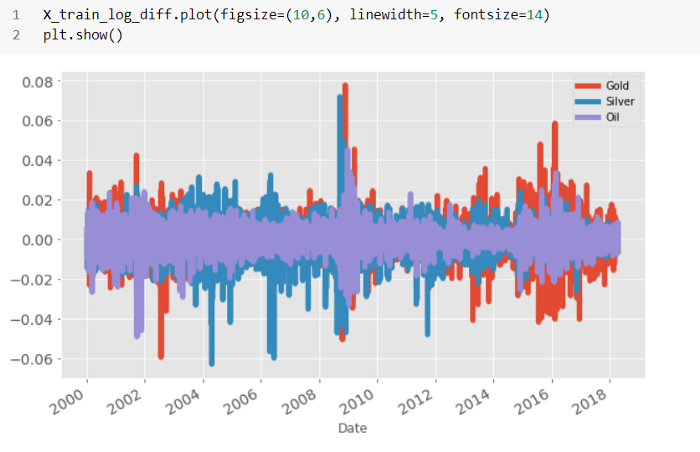

### Auto-Correlation Function Analysis of Transformed Series

In [ ]:
temp_df = pd.DataFrame()

var_log_dif = ['v_flow_mean_log_diff', 'v_loss_cover_log_diff', 'v_rainfall_total_log_diff']

for i in mcs:
    temp_df = macrodata[macrodata['mc'] == i].copy()
    temp_df.set_index(keys = 'date', inplace = True)
    temp_df = temp_df[var_log_dif]
    
    for j in var_log_dif:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0] = plot_acf(temp_df[j], lags = 75, ax = ax[0])
        plt.title('Autocorr. MC = %s - Variable : %s' % (i, j))
        ax[1] = plot_pacf(temp_df[j], lags = 75, ax = ax[1])
        plt.title('Part. Autocorr. MC = %s - Variable : %s' % (i, j))
        plt.show()
    
    

### Split data for machine learning algorithms

In [5]:
temp_df = macrodata.copy()

data_train = pd.DataFrame()
data_test = pd.DataFrame()

for i in mcs:
    #train, test = train_test_split(temp_df[temp_df['mc'] == i], test_size = 0.2)
    nobs = 24 # 10% de 240
    train, test = temp_df[temp_df['mc'] == i].iloc[0:-nobs], temp_df[temp_df['mc'] == i].iloc[-nobs:]
    data_train = pd.concat([data_train, train], axis = 0)
    data_test = pd.concat([data_test, test], axis = 0)

print('Total data')
print('----------')
print(macrodata.shape)
print(macrodata.dtypes)
print()
print('data_train')
print('----------')
print(data_train.shape)
print(data_train.dtypes)
print()
print('data_test')
print('---------')
print(data_test.shape)
print(data_test.dtypes)

temp_df.head(10)

Total data
----------
(11520, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object

data_train
----------
(10368, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object

data_test
---------
(1152, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object


,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
0,2000-01,2000,1,7,230.4,0.000000,334.0,NaN
1,2000-02,2000,2,7,272.4,0.000133,400.0,NaN
2,2000-03,2000,3,7,321.6,0.000265,319.0,NaN
3,2000-04,2000,4,7,310.8,0.000398,248.0,NaN
4,2000-05,2000,5,7,410.0,0.000531,302.0,NaN
5,2000-06,2000,6,7,295.9,0.000663,81.0,NaN
6,2000-07,2000,7,7,244.2,0.000796,96.0,NaN
7,2000-08,2000,8,7,255.0,0.000928,64.0,NaN
8,2000-09,2000,9,7,233.8,0.001061,262.0,NaN
9,2000-10,2000,10,7,216.0,0.001194,141.0,NaN


In [ ]:
data_train.head(10)

In [ ]:
data_test.head(10)

## VAR Estimation and Analysis

**Hacer ejercicio para evaluar diferencias**

------------------

## VECM Estimation and Analysis

VECM imposes additional restriction due to the existence of non-stationary but co-integrated data forms. It utilizes the co-integration restriction information into its specifications. After the cointegration is known then the next test process is done by using error correction method. Through VECM we can interpret long term and short term equations. We need to determine the number of co-integrating relationships. The advantage of VECM over VAR is that the resulting VAR from VECM representation has more efficient coefficient estimates.

### Johansen Cointegration

In order to fit a VECM model, we need to determine the number of co-integrating relationships using a VEC rank test.

In [ ]:
df_stationary.fillna(-1, inplace = True)
df_stationary.reset_index(drop=True, inplace=True)
df_stationary.head(100)

In [ ]:
for i in mcs:
    temp_df = data_train[data_train['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

    try:
        vec_rank1 = var.vecm.select_coint_rank(temp_df, det_order = 1, k_ar_diff = 1, 
                                               method = 'trace', signif = 0.05)
        print('\nMC = %s' % i)
        print('=====================================\n')

        print(vec_rank1.summary())

    except Exception as exception:
        print('\nMC = %s' % i)
        print('=====================================')
        print(repr(exception).split('(')[1])
        print('=====================================\n')
        pass

In [ ]:
for i in mcs:
    temp_df = data_train[data_train['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

    try:
        vec_rank2 = var. vecm.select_coint_rank(temp_df, det_order = 1, k_ar_diff = 1, 
                                        method = 'maxeig', signif = 0.05)
        print('\nMC = %s' % i)
        print('=====================================\n')

        print(vec_rank1.summary())

    except Exception as exception:
        print('\nMC = %s' % i)
        print('=====================================')
        print(repr(exception).split('(')[1])
        print('=====================================\n')
        pass

**Interpretation**

The Johansen test is a test for cointegration of several I(1) time series data. “Cointegration” is the property of two time series data where both share common stochastic drift. Stochastic drift is the change in average value of the random or stochastic process. The advantage of the Johansen test comes from its ability to handle several time series variable; in contrast, the Engle-Granger test could handle only one cointegration relationship. The Johansen test relies on two types of tests: (i) trace test and (ii) maximum eigenvalue test. Assume that there is a vector autoregression (VAR) of order p:

(1)   $y_t = mu + A_1y_{t-1} + … + A_py_{t-p} + e_t$

Where y is n x 1 (n by 1) vector that are integrated of order 1 or commonly written as I(1), and et is n x 1 vector of innovations. Equation can be rewritten as:

(2)   $\hat{y}_t = mu + Py_{t-1} + \sum(G_i \hat{y}_{t-I}) + e_t$


where $P = \sum(A_i – I) \hspace{0.5cm} and \hspace{0.5cm} Gi = -\sum(A_j)$


The coefficient P has a reduced rank r < n; thus, there exists n x r matrices alpha (a) and beta (b) with rank r such that P = ab’ and b’y is stationary. Recall that r is the number of relationships. The elements of a is known as the adjustment parameters in the vector error correction model (VECM), b is the vector column of cointegrating vector. The objective is to show that for a given r “what is the likelihood estimator of b defining the combination vector $y_{t-1}$ that produces r the largest conanical correlations of $\hat{y}_t$ with $y_{t-1}$ ?” In answer this question the trace test and eigenvalue test are used.

(4)   $J_{trace} = -T(\sum(ln(1 – L_i))$

(5)   $J_{max} = -T ln(l - L_{r+1})$

… where T = sample size, L is the largest canonical correlation. Under the trace test, the null hypothesis of r conintegrating vectors against the alternative hypothesis n cointegrating vectors. Under the eigenvalue test, the null hypothesis of r conintegrating vector against the alternative hypothesis of r + 1 cointegrating vectors.

INTERPRETATION

From the two tests, read the largest canonical correlation of $\hat{y}_t$ with $y_{t-1}$. Both trace test and eigenvalue test are based on pure unit root assumption. When the variables are near-unit-root process, this assumption will not be correct. The interpretation is the interpretation of correlation. However, in this case, the correlation is a correlation for vector variables in time series. The objective of the test is to verify if the two variables---in this case spot price and future price---have a common stochastic drift. The rationale of the test is that any variable that is not I(1) or a pure unit root process is a stationary I(0) process.

REFERENCES:

Johansen, Søren (1991). "Estimation and Hypothesis Testing of Cointegration Vectors in Gaussian Vector Autoregressive Models". Econometrica 59 (6): 1551–1580. JSTOR 2938278.




Source : https://www.researchgate.net/post/How_do_I_interpret_trace_statistic_and_Max-Eigen_statistics_in_the_Johansen_cointegration_test

Hypothesis


$H_o$ : There is a unit root, or no cointegration.

$H_a$ : The series has cointegration


In the Johansen cointegration test; When we use trace test statistic and eigenvalue test statistic we find that the test statistics are greater than the critical values, therefore the probability of making mistakes rejecting the null hypothesis is very small; therefore we reject it: **The series do have cointegration, therefore it is valid to run a Vector Error Correction Model (VECM).**

In [6]:
dates = pd.DataFrame(pd.date_range('2018-01-01','2019-12-31' , freq='1M') - 
             pd.offsets.MonthBegin(1))
dates.columns = ['date']

dates['year'] = pd.DatetimeIndex(dates['date']).year
dates['month'] = pd.DatetimeIndex(dates['date']).month

dates.head()

,date,year,month
0,2018-01-01,2018,1
1,2018-02-01,2018,2
2,2018-03-01,2018,3
3,2018-04-01,2018,4
4,2018-05-01,2018,5


### VECM (Vector Error Correction Model)

In [ ]:
def VECM_complete(mbasin, train, test, diff = 12, coint_r = 3, determ = 'ci'):

    forecast_steps = test[test['mc'] == mbasin].shape[0]

    temp_df = train[train['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)
    
    print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean())

    vecm = var.vecm.VECM(endog = temp_df, k_ar_diff = diff, coint_rank = coint_r, 
                         deterministic = determ)
    vecm_fit = vecm.fit()
    vecm_fit.predict(steps = forecast_steps)
#     print(vecm_fit.predict(steps = forecast_steps))
    
    forecast, lower, upper = vecm_fit.predict(steps = forecast_steps, alpha = 0.05)
#     print('lower bounds of confidence intervals:')
#     print(lower.round(3))
#     print('\npoint forecasts:')
#     print(forecast.round(3))
#     print('\nupper bounds of confidence intervals:')
#     print(upper.round(3))

    df_lower = pd.DataFrame(lower, columns = ['v_flow_mean_lower', 'v_loss_cover_lower', 
                                              'v_rainfall_total_lower'])
    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean_mean', 'v_loss_cover_mean', 
                                              'v_rainfall_total_mean'])
    df_upper = pd.DataFrame(upper, columns = ['v_flow_mean_upper', 'v_loss_cover_upper', 
                                              'v_rainfall_total_upper'])
    df_forecast_complete = pd.concat([dates, df_lower, df_forecast, df_upper], axis = 1)

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.zip'
#     df_forecast_complete.to_csv(name_file, index = False, compression = 'zip')

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.csv'
#     df_forecast_complete.to_csv(name_file, index = False)
    
    temp_df = test[test['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)

    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean', 'v_loss_cover', 
                                                    'v_rainfall_total'])
   
    print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean(), temp_df.v_loss_cover.mean(),
         temp_df.v_rainfall_total.mean(), df_forecast.v_flow_mean.mean())

    forecast_errors = [temp_df.v_flow_mean.iloc[i] - df_forecast.v_flow_mean.iloc[i] 
                       for i in range(forecast_steps)]
    bias = sum(forecast_errors) * 1.0 / (forecast_steps)
#     print('Bias : %f' % bias)

    mae = skm.mean_absolute_error(temp_df.v_flow_mean, df_forecast.v_flow_mean)
#     print('MAE : %f' % mae)

    mse = skm.mean_squared_error(temp_df.v_flow_mean, df_forecast.v_flow_mean)
    rmse = np.sqrt(mse)
#     print('MSE : %f' % mse)
#     print('RMSE : %f' % rmse) 
    
    resultados = [mbasin, bias, mae, mse, rmse]
    resultados = pd.DataFrame([resultados], columns = ['mc', 'Bias', 'MAE', 'MSE', 'RMSE'])
    
#     print(resultados.head())
#     print('===========================================================\n')

    prediction = pd.concat([df_forecast_complete, temp_df], axis = 1)
    prediction['mc'] = mbasin
    prediction = prediction[['date', 'year', 'month', 'mc', 'v_flow_mean_lower', 
                             'v_flow_mean_mean', 'v_flow_mean_upper', 
                             'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

#     vecm_fit.plot_forecast(steps = forecast_steps, n_last_obs = forecast_steps)
    
    return (resultados, prediction)

# VECM_complete(10, data_train, data_test, 12, 3, 'ci')

In [ ]:
VECM_metrics = pd.DataFrame()
VECM_prediction = pd.DataFrame()

for i, mbasin in enumerate(mcs):
    metrics, prediction = VECM_complete(mbasin, data_train, data_test, 12, 3, 'ci')
    VECM_metrics = pd.concat([VECM_metrics, metrics], axis = 0)
    VECM_prediction = pd.concat([VECM_prediction, prediction], axis = 0)

In [ ]:
VECM_metrics.to_csv('../model/VECM_results_v1.csv', index = False)
VECM_metrics.head()

In [ ]:
VECM_prediction['v_flow_mean_mean'] = VECM_prediction['v_flow_mean_mean'].apply(lambda x: 
                                                                              0.01 if x <= 0 
                                                                              else x)
VECM_prediction.to_csv('../model/VECM_predictions_v1.csv', index = False)

VECM_prediction.head()

------------------

### VECM (Vector Error Correction Model) - Prediction 2020 - 2021

#### Read scenarios for independent variables

In [5]:
scenarios = pd.read_excel('../data/matrix/Esc_Predicciones_longitudinal.xlsx')

scenarios['v_flow_mean'] = 0

scenarios = scenarios[['date', 'mc', 'v_flow_mean', 'v_loss_cover', 'v_rainfall_total', 
                       'scenario']]

scenarios.head(10)

,date,mc,v_flow_mean,v_loss_cover,v_rainfall_total,scenario
0,2020-01-01,1,0,0.07693,210.44,Def_25%_P_A1
1,2020-02-01,1,0,0.07702,135.49,Def_25%_P_A1
2,2020-03-01,1,0,0.07710,259.40,Def_25%_P_A1
3,2020-04-01,1,0,0.07718,61.71,Def_25%_P_A1
4,2020-05-01,1,0,0.07726,202.86,Def_25%_P_A1
5,2020-06-01,1,0,0.07735,137.33,Def_25%_P_A1
6,2020-07-01,1,0,0.07743,14.20,Def_25%_P_A1
7,2020-08-01,1,0,0.07751,20.29,Def_25%_P_A1
8,2020-09-01,1,0,0.07759,3.46,Def_25%_P_A1
9,2020-10-01,1,0,0.07768,78.47,Def_25%_P_A1


In [6]:
dates = pd.DataFrame(pd.date_range('2020-01-01','2021-12-31' , freq='1M') - 
             pd.offsets.MonthBegin(1))
dates.columns = ['date']

dates['year'] = pd.DatetimeIndex(dates['date']).year
dates['month'] = pd.DatetimeIndex(dates['date']).month

dates.head()

,date,year,month
0,2020-01-01,2020,1
1,2020-02-01,2020,2
2,2020-03-01,2020,3
3,2020-04-01,2020,4
4,2020-05-01,2020,5


In [7]:
def VECM_complete_pred(mbasin, train, test, diff = 12, coint_r = 3, determ = 'ci'):

    forecast_steps = test[test['mc'] == mbasin].shape[0]

    temp_df = train[train['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df['v_loss_cover'] = temp_df['v_loss_cover'] * 100
    temp_df.reset_index(drop=True, inplace=True)
    
#     print(mbasin, temp_df.shape, temp_df.v_flow_mean.mean())

    vecm = var.vecm.VECM(endog = temp_df, k_ar_diff = diff, coint_rank = coint_r, 
                         deterministic = determ)
    vecm_fit = vecm.fit()
    vecm_fit.predict(steps = forecast_steps)
#     print(vecm_fit.predict(steps = forecast_steps))
    
    forecast, lower, upper = vecm_fit.predict(steps = forecast_steps, alpha = 0.05)
#     print('lower bounds of confidence intervals:')
#     print(lower.round(3))
#     print('\npoint forecasts:')
#     print(forecast.round(3))
#     print('\nupper bounds of confidence intervals:')
#     print(upper.round(3))

    df_lower = pd.DataFrame(lower, columns = ['v_flow_mean_lower', 'v_loss_cover_lower', 
                                              'v_rainfall_total_lower'])
    df_forecast = pd.DataFrame(forecast, columns = ['v_flow_mean_mean', 'v_loss_cover_mean', 
                                              'v_rainfall_total_mean'])
    df_upper = pd.DataFrame(upper, columns = ['v_flow_mean_upper', 'v_loss_cover_upper', 
                                              'v_rainfall_total_upper'])
    df_forecast_complete = pd.concat([dates, df_lower, df_forecast, df_upper], axis = 1)

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.zip'
#     df_forecast_complete.to_csv(name_file, index = False, compression = 'zip')

#     name_file = '../temp/VECM_MC_' + str(mbasin) + '.csv'
#     df_forecast_complete.to_csv(name_file, index = False)
    
    temp_df = test[test['mc'] == mbasin].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)

    prediction = pd.concat([df_forecast_complete, temp_df], axis = 1)
    prediction['mc'] = mbasin
    prediction = prediction[['date', 'year', 'month', 'mc', 'v_flow_mean_lower', 
                             'v_flow_mean_mean', 'v_flow_mean_upper', 
                             'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]

    print(mbasin, prediction.shape, prediction.v_flow_mean_mean.mean(), 
         prediction.v_loss_cover.mean(), prediction.v_rainfall_total.mean())
    
#     vecm_fit.plot_forecast(steps = forecast_steps, n_last_obs = forecast_steps)
    
    return (prediction)

# VECM_complete(10, data_train, data_test, 12, 3, 'ci')

In [8]:
escen = scenarios['scenario'].unique()

data_train_predict = macrodata.copy()

VECM_prediction = pd.DataFrame()

for j in escen:
    
    data_test_predict = scenarios[scenarios['scenario'] == j].copy()

    for i, mbasin in enumerate(mcs):
        
        print('\n==================================')
        print('Escenario :', j, '\n')
        
        prediction = VECM_complete_pred(mbasin, data_train_predict, data_test_predict,
                                        12, 3, 'ci')
        prediction['scenario'] = j
        prediction.drop(columns = ['v_flow_mean_lower', 'v_flow_mean_upper',
                                   'v_flow_mean'], inplace = True)    
        prediction.columns = ['date', 'year', 'month', 'mc', 'v_flow_mean_forecast', 
                              'v_loss_cover', 'v_rainfall_total', 'scenario']        
        VECM_prediction = pd.concat([VECM_prediction, prediction], axis = 0)


Escenario : Def_25%_P_A1 

1 (24, 10) 3.107610128287209 0.0778825 122.51666666666665

Escenario : Def_25%_P_A1 

2 (24, 10) 23.361114319193522 0.06186 196.54625000000001

Escenario : Def_25%_P_A1 

3 (24, 10) 160.2956868684847 0.026649999999999997 134.41375000000002

Escenario : Def_25%_P_A1 

4 (24, 10) 4.82413718049679 0.08403000000000001 240.80291666666665

Escenario : Def_25%_P_A1 

5 (24, 10) 68.89045966395136 0.03289 77.28083333333333

Escenario : Def_25%_P_A1 

6 (24, 10) 17.915774626293018 0.021095000000000003 147.3658333333333

Escenario : Def_25%_P_A1 

7 (24, 10) 241.76856351464428 0.035175 202.8575

Escenario : Def_25%_P_A1 

8 (24, 10) 41.53866538460155 0.023440000000000003 186.5583333333333

Escenario : Def_25%_P_A1 

9 (24, 10) 14.944223957406054 0.006492499999999999 95.60208333333333

Escenario : Def_25%_P_A1 

10 (24, 10) 12.437558431235024 0.070075 197.0254166666667

Escenario : Def_25%_P_A1 

11 (24, 10) 19.032598297962952 0.0250975 81.26666666666667

Escenario : De

25 (24, 10) 7.662468090041545 0.06510500000000001 90.60833333333333

Escenario : Def_50%_P_A1 

26 (24, 10) 63.95936012910095 0.070475 170.33666666666667

Escenario : Def_50%_P_A1 

27 (24, 10) 15.502076328388517 0.04548 90.42875

Escenario : Def_50%_P_A1 

28 (24, 10) 64.22011817153138 0.0618 315.35833333333335

Escenario : Def_50%_P_A1 

29 (24, 10) 60.16027363566559 0.01832 821.2666666666668

Escenario : Def_50%_P_A1 

30 (24, 10) 9.100829838120148 0.033785 194.44333333333336

Escenario : Def_50%_P_A1 

31 (24, 10) 8.984535286573486 0.028130000000000002 113.38958333333333

Escenario : Def_50%_P_A1 

32 (24, 10) 37.12436846007889 0.024395 99.18583333333333

Escenario : Def_50%_P_A1 

33 (24, 10) 4.439603551084591 0.027249999999999996 211.03708333333336

Escenario : Def_50%_P_A1 

34 (24, 10) 366.80107690180245 0.037965000000000006 228.2658333333333

Escenario : Def_50%_P_A1 

35 (24, 10) 395.8661194810482 0.09734 318.62083333333334

Escenario : Def_50%_P_A1 

36 (24, 10) 156.10746435

6 (24, 10) 17.915774626293018 0.021935 147.3658333333333

Escenario : Def_100%_P_A1 

7 (24, 10) 241.76856351464428 0.03649 202.8575

Escenario : Def_100%_P_A1 

8 (24, 10) 41.53866538460155 0.02438 186.5583333333333

Escenario : Def_100%_P_A1 

9 (24, 10) 14.944223957406054 0.006775 95.60208333333333

Escenario : Def_100%_P_A1 

10 (24, 10) 12.437558431235024 0.0727 197.0254166666667

Escenario : Def_100%_P_A1 

11 (24, 10) 19.032598297962952 0.026125 81.26666666666667

Escenario : Def_100%_P_A1 

12 (24, 10) 15.448890648540186 0.033679999999999995 118.27625

Escenario : Def_100%_P_A1 

13 (24, 10) 315.5783774230362 0.060675 308.4583333333333

Escenario : Def_100%_P_A1 

14 (24, 10) 68.05587438161642 0.018365 157.24916666666664

Escenario : Def_100%_P_A1 

15 (24, 10) 63.53951350987895 0.216365 195.83874999999998

Escenario : Def_100%_P_A1 

16 (24, 10) 408.38256864496424 0.106545 170.35833333333335

Escenario : Def_100%_P_A1 

17 (24, 10) 11.915344545276833 0.04813 122.5

Escenario :

26 (24, 10) 63.95936012910095 0.06956999999999999 180.22916666666666

Escenario : Def_25%_P_A2 

27 (24, 10) 15.502076328388517 0.044885 95.13125000000001

Escenario : Def_25%_P_A2 

28 (24, 10) 64.22011817153138 0.06102 297.17833333333334

Escenario : Def_25%_P_A2 

29 (24, 10) 60.16027363566559 0.0181025 767.8266666666668

Escenario : Def_25%_P_A2 

30 (24, 10) 9.100829838120148 0.033345 186.95916666666668

Escenario : Def_25%_P_A2 

31 (24, 10) 8.984535286573486 0.027755 108.83708333333333

Escenario : Def_25%_P_A2 

32 (24, 10) 37.12436846007889 0.02408 97.17875

Escenario : Def_25%_P_A2 

33 (24, 10) 4.439603551084591 0.0269075 202.45333333333335

Escenario : Def_25%_P_A2 

34 (24, 10) 366.80107690180245 0.037524999999999996 223.06208333333333

Escenario : Def_25%_P_A2 

35 (24, 10) 395.8661194810482 0.09621500000000001 316.1879166666667

Escenario : Def_25%_P_A2 

36 (24, 10) 156.1074643546855 0.089015 252.70083333333332

Escenario : Def_25%_P_A2 

37 (24, 10) 109.28315040078392 

1 (24, 10) 3.107610128287209 0.079945 117.64333333333333

Escenario : Def_75%_P_A2 

2 (24, 10) 23.361114319193522 0.06336 194.63458333333332

Escenario : Def_75%_P_A2 

3 (24, 10) 160.2956868684847 0.0273375 133.51916666666668

Escenario : Def_75%_P_A2 

4 (24, 10) 4.82413718049679 0.0862175 233.23124999999996

Escenario : Def_75%_P_A2 

5 (24, 10) 68.89045966395136 0.033702499999999996 77.09333333333332

Escenario : Def_75%_P_A2 

6 (24, 10) 17.915774626293018 0.0216575 146.37166666666667

Escenario : Def_75%_P_A2 

7 (24, 10) 241.76856351464428 0.036050000000000006 203.53208333333336

Escenario : Def_75%_P_A2 

8 (24, 10) 41.53866538460155 0.024065 188.5404166666667

Escenario : Def_75%_P_A2 

9 (24, 10) 14.944223957406054 0.006679999999999999 93.24416666666666

Escenario : Def_75%_P_A2 

10 (24, 10) 12.437558431235024 0.07182499999999999 203.67249999999999

Escenario : Def_75%_P_A2 

11 (24, 10) 19.032598297962952 0.025785000000000002 83.36166666666666

Escenario : Def_75%_P_A2 

1

21 (24, 10) 9.419289948732612 0.048495 65.01875

Escenario : Def_100%_P_A2 

22 (24, 10) 222.70930946907643 0.026465 203.20708333333332

Escenario : Def_100%_P_A2 

23 (24, 10) 159.65829734230843 0.05114 213.25291666666666

Escenario : Def_100%_P_A2 

24 (24, 10) 15.692562863499242 0.18657500000000002 152.93500000000003

Escenario : Def_100%_P_A2 

25 (24, 10) 7.662468090041545 0.06673 94.55250000000001

Escenario : Def_100%_P_A2 

26 (24, 10) 63.95936012910095 0.072285 180.22916666666666

Escenario : Def_100%_P_A2 

27 (24, 10) 15.502076328388517 0.046665000000000005 95.13125000000001

Escenario : Def_100%_P_A2 

28 (24, 10) 64.22011817153138 0.063365 297.17833333333334

Escenario : Def_100%_P_A2 

29 (24, 10) 60.16027363566559 0.018754999999999997 767.8266666666668

Escenario : Def_100%_P_A2 

30 (24, 10) 9.100829838120148 0.03466 186.95916666666668

Escenario : Def_100%_P_A2 

31 (24, 10) 8.984535286573486 0.02888 108.83708333333333

Escenario : Def_100%_P_A2 

32 (24, 10) 37.124368

45 (24, 10) 836.3597266037503 0.18664 262.7916666666667

Escenario : Def_25%_P_B1 

46 (24, 10) 2312.6766704465304 0.147855 234.6449125

Escenario : Def_25%_P_B1 

47 (24, 10) 3063.0639474103587 0.08155 239.82534583333336

Escenario : Def_25%_P_B1 

48 (24, 10) 4074.06679316 0.06716749999999999 240.15533749999997

Escenario : Def_50%_P_B1 

1 (24, 10) 3.107610128287209 0.078915 129.75333333333333

Escenario : Def_50%_P_B1 

2 (24, 10) 23.361114319193522 0.06261 213.70125

Escenario : Def_50%_P_B1 

3 (24, 10) 160.2956868684847 0.026995 143.84916666666666

Escenario : Def_50%_P_B1 

4 (24, 10) 4.82413718049679 0.085125 255.3145833333333

Escenario : Def_50%_P_B1 

5 (24, 10) 68.89045966395136 0.033295 85.74000000000001

Escenario : Def_50%_P_B1 

6 (24, 10) 17.915774626293018 0.021375 163.23333333333332

Escenario : Def_50%_P_B1 

7 (24, 10) 241.76856351464428 0.035615 217.70416666666665

Escenario : Def_50%_P_B1 

8 (24, 10) 41.53866538460155 0.023755 201.34166666666667

Escenario : De

26 (24, 10) 63.95936012910095 0.0713825 176.83124999999998

Escenario : Def_75%_P_B1 

27 (24, 10) 15.502076328388517 0.046072499999999995 92.63416666666666

Escenario : Def_75%_P_B1 

28 (24, 10) 64.22011817153138 0.0625825 303.15833333333336

Escenario : Def_75%_P_B1 

29 (24, 10) 60.16027363566559 0.01854 775.7195833333334

Escenario : Def_75%_P_B1 

30 (24, 10) 9.100829838120148 0.03422 208.53706923079164

Escenario : Def_75%_P_B1 

31 (24, 10) 8.984535286573486 0.028505 123.3125

Escenario : Def_75%_P_B1 

32 (24, 10) 37.12436846007889 0.024705 107.26041666666667

Escenario : Def_75%_P_B1 

33 (24, 10) 4.439603551084591 0.027594999999999998 219.6933333333333

Escenario : Def_75%_P_B1 

34 (24, 10) 366.80107690180245 0.0384 252.836560725

Escenario : Def_75%_P_B1 

35 (24, 10) 395.8661194810482 0.09846500000000001 335.66170755708333

Escenario : Def_75%_P_B1 

36 (24, 10) 156.1074643546855 0.09126499999999999 258.2021482880833

Escenario : Def_75%_P_B1 

37 (24, 10) 109.28315040078

2 (24, 10) 23.361114319193522 0.06186 193.1620833333333

Escenario : Def_25%_P_B2 

3 (24, 10) 160.2956868684847 0.026649999999999997 132.32583333333332

Escenario : Def_25%_P_B2 

4 (24, 10) 4.82413718049679 0.08403000000000001 233.0979166666667

Escenario : Def_25%_P_B2 

5 (24, 10) 68.89045966395136 0.03289 77.47458333333333

Escenario : Def_25%_P_B2 

6 (24, 10) 17.915774626293018 0.021095000000000003 146.05166666666668

Escenario : Def_25%_P_B2 

7 (24, 10) 241.76856351464428 0.035175 202.12125

Escenario : Def_25%_P_B2 

8 (24, 10) 41.53866538460155 0.023440000000000003 188.05958333333334

Escenario : Def_25%_P_B2 

9 (24, 10) 14.944223957406054 0.006492499999999999 94.04833333333333

Escenario : Def_25%_P_B2 

10 (24, 10) 12.437558431235024 0.070075 206.2891666666667

Escenario : Def_25%_P_B2 

11 (24, 10) 19.032598297962952 0.0250975 85.59541666666667

Escenario : Def_25%_P_B2 

12 (24, 10) 15.448890648540186 0.03237 116.41875

Escenario : Def_25%_P_B2 

13 (24, 10) 315.5783774

27 (24, 10) 15.502076328388517 0.04548 95.54875

Escenario : Def_50%_P_B2 

28 (24, 10) 64.22011817153138 0.0618 298.93291666666664

Escenario : Def_50%_P_B2 

29 (24, 10) 60.16027363566559 0.01832 770.8145833333334

Escenario : Def_50%_P_B2 

30 (24, 10) 9.100829838120148 0.033785 187.1641666666667

Escenario : Def_50%_P_B2 

31 (24, 10) 8.984535286573486 0.028130000000000002 107.44166666666666

Escenario : Def_50%_P_B2 

32 (24, 10) 37.12436846007889 0.024395 96.50875

Escenario : Def_50%_P_B2 

33 (24, 10) 4.439603551084591 0.027249999999999996 203.94583333333335

Escenario : Def_50%_P_B2 

34 (24, 10) 366.80107690180245 0.037965000000000006 222.98708333333335

Escenario : Def_50%_P_B2 

35 (24, 10) 395.8661194810482 0.09734 317.45875

Escenario : Def_50%_P_B2 

36 (24, 10) 156.1074643546855 0.09014 255.37749999999997

Escenario : Def_50%_P_B2 

37 (24, 10) 109.28315040078392 0.03624 182.37541666666667

Escenario : Def_50%_P_B2 

38 (24, 10) 55.138706322190124 0.024515 93.8545833333

3 (24, 10) 160.2956868684847 0.027684999999999998 132.32583333333332

Escenario : Def_100%_P_B2 

4 (24, 10) 4.82413718049679 0.08731499999999999 233.0979166666667

Escenario : Def_100%_P_B2 

5 (24, 10) 68.89045966395136 0.034104999999999996 77.47458333333333

Escenario : Def_100%_P_B2 

6 (24, 10) 17.915774626293018 0.021935 146.05166666666668

Escenario : Def_100%_P_B2 

7 (24, 10) 241.76856351464428 0.03649 202.12125

Escenario : Def_100%_P_B2 

8 (24, 10) 41.53866538460155 0.02438 188.05958333333334

Escenario : Def_100%_P_B2 

9 (24, 10) 14.944223957406054 0.006775 94.04833333333333

Escenario : Def_100%_P_B2 

10 (24, 10) 12.437558431235024 0.0727 206.2891666666667

Escenario : Def_100%_P_B2 

11 (24, 10) 19.032598297962952 0.026125 85.59541666666667

Escenario : Def_100%_P_B2 

12 (24, 10) 15.448890648540186 0.033679999999999995 116.41875

Escenario : Def_100%_P_B2 

13 (24, 10) 315.5783774230362 0.060675 297.49291666666664

Escenario : Def_100%_P_B2 

14 (24, 10) 68.0558743816

In [9]:
print(VECM_prediction.shape)

VECM_prediction.head(100)

(18432, 8)


,date,year,month,mc,v_flow_mean_forecast,v_loss_cover,v_rainfall_total,scenario
0,2020-01-01,2020,1,1,1.809192,0.07693,210.44,Def_25%_P_A1
1,2020-02-01,2020,2,1,1.703153,0.07702,135.49,Def_25%_P_A1
2,2020-03-01,2020,3,1,2.129287,0.07710,259.40,Def_25%_P_A1
3,2020-04-01,2020,4,1,2.771212,0.07718,61.71,Def_25%_P_A1
4,2020-05-01,2020,5,1,3.568170,0.07726,202.86,Def_25%_P_A1
...,...,...,...,...,...,...,...,...
23,2021-12-01,2021,12,4,6.354931,0.08504,358.07,Def_25%_P_A1
0,2020-01-01,2020,1,5,65.403997,0.03252,0.00,Def_25%_P_A1
1,2020-02-01,2020,2,5,61.661215,0.03255,31.55,Def_25%_P_A1
2,2020-03-01,2020,3,5,66.440725,0.03258,58.59,Def_25%_P_A1


In [10]:
VECM_prediction['v_flow_mean_forecast'] = VECM_prediction['v_flow_mean_forecast'].apply(lambda x: 
                                                                              0.01 if x <= 0 
                                                                              else x)
VECM_prediction.to_csv('../model/VECM_forecast_2020_2021.csv', index = False)